In [1]:
pip install transformers

In [2]:
pip install datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        texts=df.tweet.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

In [5]:
df = pd.read_csv('tweets.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [6]:
print(train_df.shape)
print(test_df.shape)

(1364, 2)
(342, 2)


In [7]:
model_name = 'dbmdz/bert-base-turkish-cased'

tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
tokenized_length = []
tokenized_length = df['tweet'].apply(lambda tweet: len(tokenizer.encode(tweet, add_special_tokens=True)))

print("Min length:", tokenized_length.min())
print("Max length:", tokenized_length.max())

Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


Min length: 5
Max length: 565


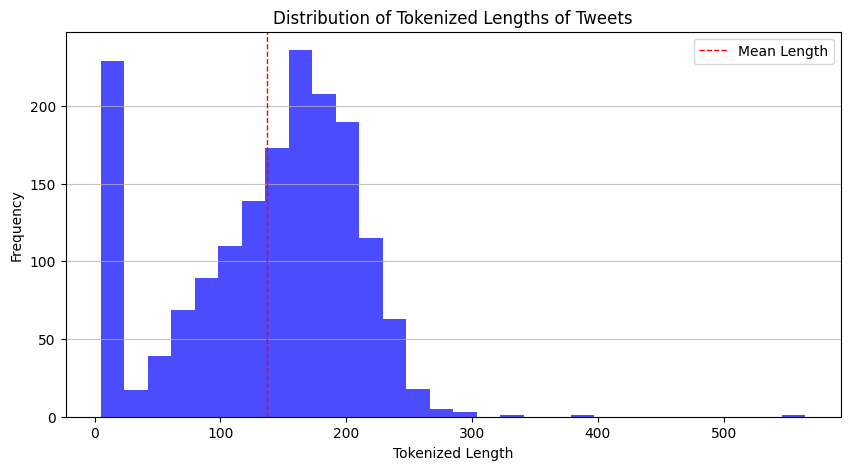

In [9]:
plt.figure(figsize=(10, 5))

plt.hist(tokenized_length, bins=30, color='blue', alpha=0.7)

plt.title('Distribution of Tokenized Lengths of Tweets')
plt.xlabel('Tokenized Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.axvline(x=tokenized_length.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean Length')

plt.legend()
plt.show()

In [10]:
MAX_LEN = 512
BATCH_SIZE = 8

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [11]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased', num_labels=n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.logits

    def save_model(self, path):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")

model = SentimentClassifier(n_classes=2)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        total_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader)

In [14]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == labels).sum().item()

            all_y_true.extend(labels.cpu().numpy())
            all_y_pred.extend(predictions.cpu().numpy())

    accuracy = total_correct / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)

    return accuracy, avg_loss, all_y_true, all_y_pred

Epoch 1/4
Train loss: 0.6612495080682269
Test accuracy: 0.8128654970760234, Test loss: 0.4604594125304111
Epoch 2/4
Train loss: 0.4802760643045805
Test accuracy: 0.8391812865497076, Test loss: 0.578671989485968
Epoch 3/4
Train loss: 0.3676692157689678
Test accuracy: 0.8596491228070176, Test loss: 0.5253576290533813
Epoch 4/4
Train loss: 0.27383716493077054
Test accuracy: 0.8596491228070176, Test loss: 0.5494940256873189


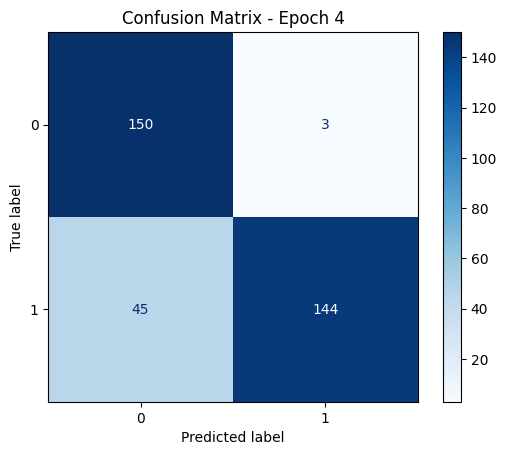

In [15]:
EPOCHS = 4
train_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device)
    test_accuracy, test_loss, y_true, y_pred = eval_model(model, test_data_loader, loss_fn, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(test_accuracy)

    print(f"Train loss: {train_loss}")
    print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

    if epoch == EPOCHS - 1:

      cm = confusion_matrix(y_true, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
      disp.plot(cmap=plt.cm.Blues)
      plt.title(f"Confusion Matrix - Epoch {epoch + 1}")
    plt.show()

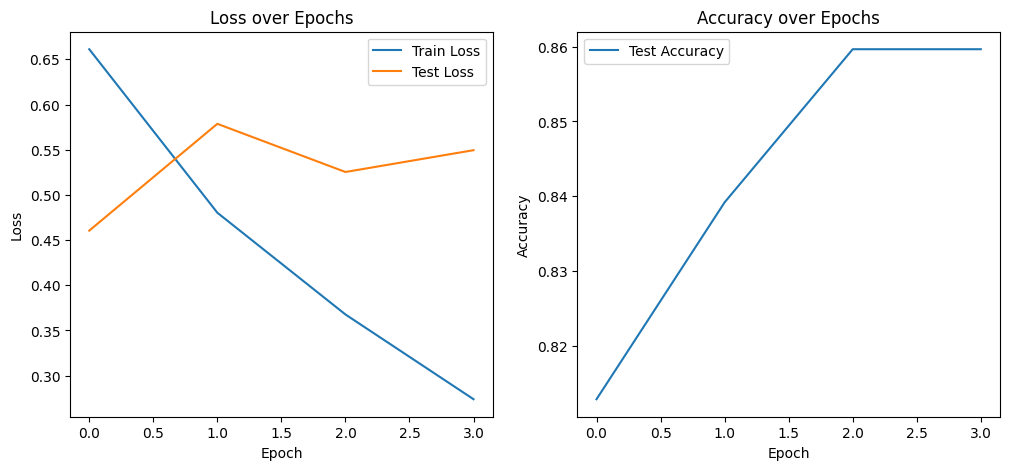

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
def get_prediction_sample(model, data_loader, device):
    model = model.eval()

    tweets = []
    true_labels = []
    pred_labels = []
    pred_probs = []

    with torch.no_grad():
        for d in data_loader:
            inputs = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(inputs, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            tweets.extend(d['tweet'])
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            pred_probs.extend(outputs.cpu().numpy())

    return tweets, true_labels, pred_labels, pred_probs


In [18]:
tweets, true_labels, pred_labels, pred_probs = get_prediction_sample(model, test_data_loader, device)

In [19]:
df_predictions = pd.DataFrame({
    'tweet': tweets,
    'true_label': true_labels,
    'pred_label': pred_labels,
    'pred_prob': pred_probs
})

display(df_predictions.tail())

,tweet,true_label,pred_label,pred_prob
337,Perşembe günü satıcılı bir seyir izleyen hisse...,0,0,"[1.691176, -2.2931855]"
338,Nisan ayına olumlu bir başlangıç yapan BISTde...,1,1,"[-3.2459288, 3.904936]"
339,Yükselişte Banka hisselerinin liderliği devam ...,1,1,"[-3.2585266, 3.9193826]"
340,Son günlerde 4.400 üzerinde tutunmakta zorlana...,1,0,"[0.298494, -1.3942589]"
341,Kısa vadeli yükseliş trendi içerisindeki güçlü...,1,1,"[-3.2425551, 3.8936682]"


In [20]:
df_predictions[df_predictions["true_label"] != df_predictions["pred_label"]].head()

,tweet,true_label,pred_label,pred_prob
5,Güne alıcılı bir seyirle başlayan BIST-100 End...,1,0,"[1.6933488, -2.2994764]"
25,Borsa İstanbulda geçen hafta çarşamba gününde...,1,0,"[1.6911343, -2.2932775]"
29,Bayram nedeniyle kısalan geçen haftada satış a...,1,0,"[1.6975985, -2.3316395]"
33,Dün BIST banka ve holding hisselerine gelen al...,1,0,"[1.6909903, -2.2923093]"
35,Perşembe günü gelecek ABD verisi öncesi yurt d...,1,0,"[1.6912946, -2.2938154]"


In [21]:
save_directory = "./model"

model.save_model(save_directory)

Model saved to ./model


Model Drive Link:  

https://drive.google.com/file/d/1CGN1pHs03Onv__vTT-4hvBPvUH3T-uIK/view?usp=sharing